<a href="https://colab.research.google.com/github/dIcarusb/Master_project/blob/master/DeconvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeconvNet model
Importing libraries

In [0]:

import numpy as np
import matplotlib.pyplot as plt
import time
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers.merge import *
from numpy.random import shuffle
from numpy.random import seed
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score


## Loading the dataset

In [0]:
from google.colab import files

uploaded = files.upload()

Saving y.npy to y.npy


In [0]:
y = np.load('y.npy')
x = np.load('x.npy')

Transforming "y" into 3 classes/3 dimensiones, with the help of dummy function:

In [0]:
def dummy(y):
  NewY = np.zeros(448*120*120*3)
  Y = np.reshape(NewY, (448,120,120,3))
  
  for i in range(0,447):
    for j in range(0,119):
      for k in range(0,119):
        if y[i][j][k]==0:
          Y[i][j][k][0]=1
        elif y[i][j][k]==128:
          Y[i][j][k][1]=1
        else:
          Y[i][j][k][2]=1
        
  return(Y)

In [0]:
y = dummy(y)

"x" scaling

In [0]:
x = x/255

Random shuffle

In [0]:
seed(2)
shuffle(x)
seed(2)
shuffle(y)

Test and train partition

In [0]:
X_test = x[418:]
Y_test = y[418:]
X_train = x[0:417]
Y_train= y[0:417]

##Model
VGG16 and its inverse

In [0]:
def conv_block(tensor, nfilters, size=3, padding="same", initializer="glorot_uniform"):  
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
  
def conv1_block(tensor, nfilters, size=3, padding="same", initializer="glorot_uniform"):  
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def DeconvNet(img_height,img_width,  nclasses=3,filters=64):
    input_layer = Input(shape=(img_height, img_width, 3), name='image_input')
    
    #VGG16
    conv1 = conv_block(input_layer, nfilters=filters) 
    conv1_out = MaxPooling2D(pool_size=(1, 1))(conv1) # modified
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3 = conv1_block(conv3, nfilters=filters*4) # 7th convolutional layer
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4 = conv1_block(conv4, nfilters=filters*8) # 10th layer
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = conv_block(conv4_out, nfilters=filters*8)
    conv5 = conv1_block(conv5, nfilters=filters*8) # 13th layer
    conv5_out = MaxPooling2D(pool_size=(3, 3))(conv5) # modified
    
    fc = Dense(filters*64, activation="relu")(conv5_out) # fully conected layer
    
    #inverse-VGG16
    fc = Dense(filters*64, activation="relu")(fc) # fully conected layer
    
    up1 = UpSampling2D(size=(3, 3))(fc) # modified
    conv6 = conv_block(up1, nfilters=filters*8) # 13th layer
    conv6 = conv1_block(conv6, nfilters=filters*8)
    up2 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = conv_block(up2, nfilters=filters*8) # 10th layer
    conv7 = conv1_block(conv7, nfilters=filters*8)
    up3 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = conv_block(up3, nfilters=filters*4) # 7th layer
    conv8 = conv1_block(conv8, nfilters=filters*4)
    up4 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = conv_block(up4, nfilters=filters*2)
    up5 = UpSampling2D(size=(1, 1))(conv9) # modified
    conv10 = conv_block(up5, nfilters=filters) 
    
    
    #output
    output_layer = Conv2D(filters=nclasses, kernel_size=(1, 1))(conv10)
    output_laye = Dropout(0.5)(output_layer)
    output_layer = Activation('softmax')(output_layer)
    

    model = Model(inputs=input_layer, outputs=output_layer, name='DeconvNet')
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model
	

Building the model

In [0]:
m = DeconvNet(120, 120, nclasses=3, filters=64)
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 120, 120, 3)       0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 120, 120, 64)      1792      
_________________________________________________________________
batch_normalization_79 (Batc (None, 120, 120, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 120, 120, 64)      0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 120, 120, 64)      36928     
_________________________________________________________________
batch_normalization_80 (Batc (None, 120, 120, 64)      256       
_________________________________________________________________
activation_83 (Activation)   (None, 120, 120, 64)      0         
__________

##Training the model

In [0]:
start=time.time()
history = m.fit(X_train, Y_train,epochs=30, batch_size=20, verbose=1, validation_data=(X_test, Y_test))
end=time.time()
print("Time:")
print(end-start)

Train on 417 samples, validate on 30 samples
Epoch 1/30
417/417 [==============================] - 54s 128ms/step - loss: 0.3080 - acc: 0.8783 - val_loss: 2.3182 - val_acc: 0.6579
Epoch 2/30
417/417 [==============================] - 43s 103ms/step - loss: 0.1536 - acc: 0.9481 - val_loss: 0.5068 - val_acc: 0.8539
Epoch 3/30
417/417 [==============================] - 43s 103ms/step - loss: 0.1277 - acc: 0.9580 - val_loss: 0.2015 - val_acc: 0.9382
Epoch 4/30
417/417 [==============================] - 43s 102ms/step - loss: 0.1048 - acc: 0.9668 - val_loss: 0.1502 - val_acc: 0.9506
Epoch 5/30
417/417 [==============================] - 43s 103ms/step - loss: 0.0960 - acc: 0.9696 - val_loss: 0.1467 - val_acc: 0.9487
Epoch 6/30
417/417 [==============================] - 43s 103ms/step - loss: 0.0869 - acc: 0.9726 - val_loss: 0.2248 - val_acc: 0.9263
Epoch 7/30
417/417 [==============================] - 43s 103ms/step - loss: 0.0849 - acc: 0.9730 - val_loss: 0.1044 - val_acc: 0.9628
Epoch 8/30

##Evaluation of the model

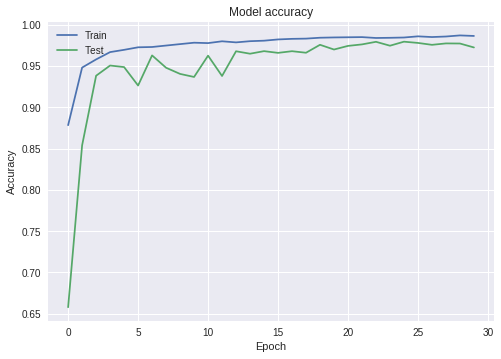

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('DeconvNet_accuracy.png')
plt.show()

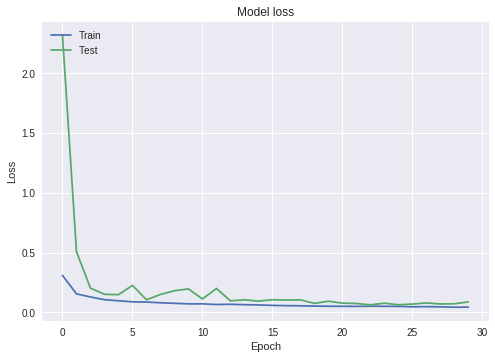

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('DeconvNet_loss.png')
plt.show()

Accuracy on test data

In [0]:
score = m.evaluate(X_test, Y_test)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

30/30 [==============================] - 6s 195ms/step

Test loss: 0.08607201278209686
Test accuracy: 0.9724436402320862


Prediction on test data

In [0]:
prediction = m.predict(X_test,verbose=1)
p = np.reshape(prediction, (30,120,120,3))
p = p.round()

30/30 [==============================] - 3s 95ms/step


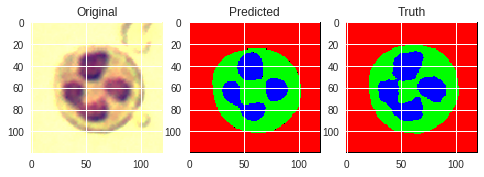

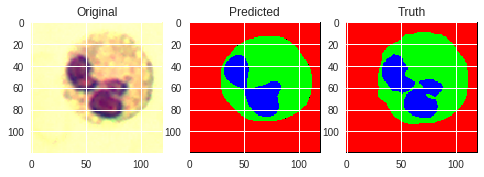

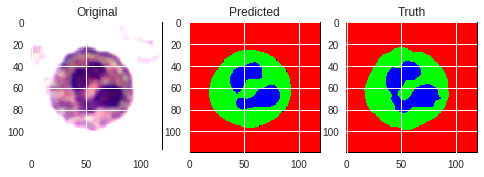

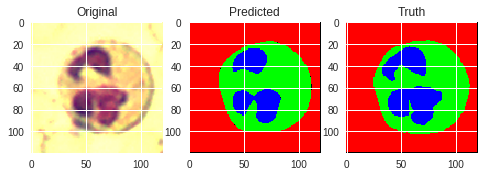

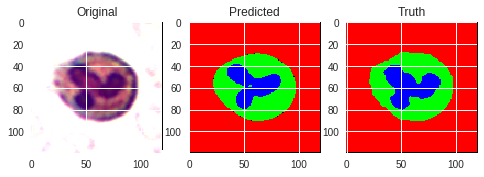

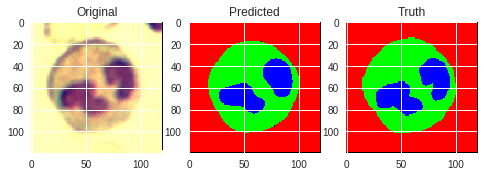

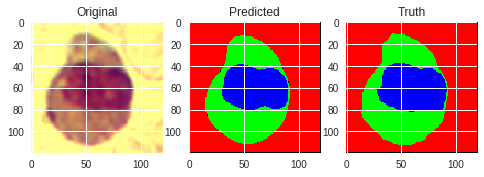

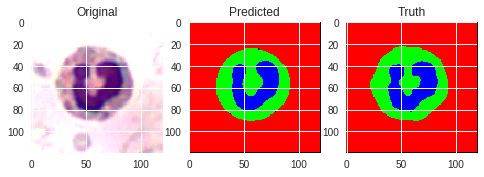

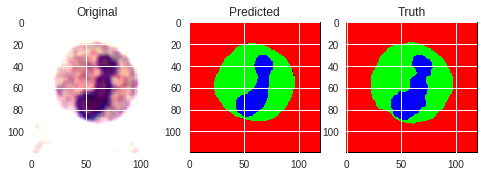

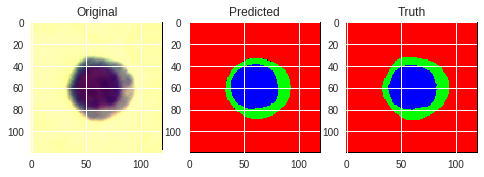

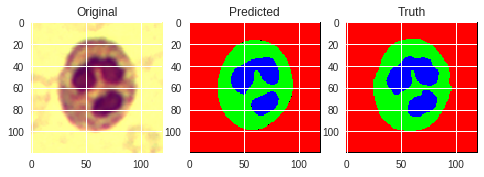

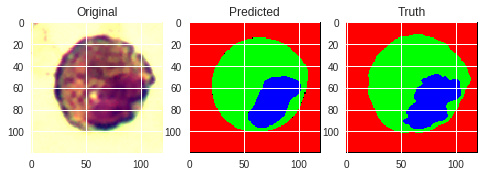

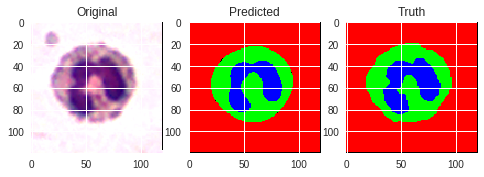

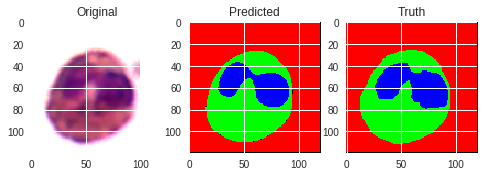

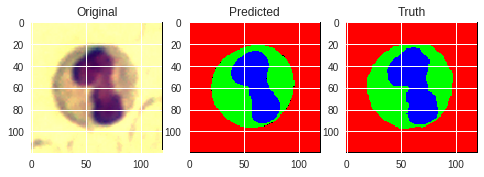

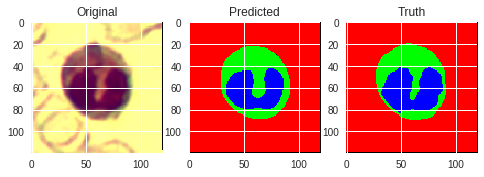

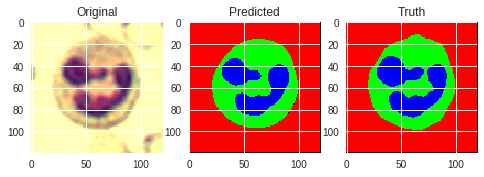

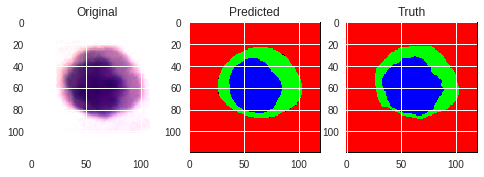

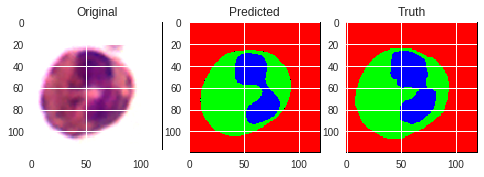

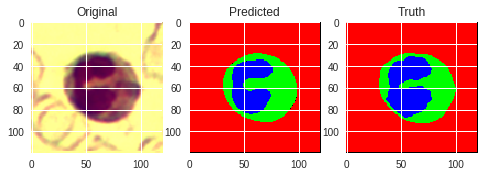

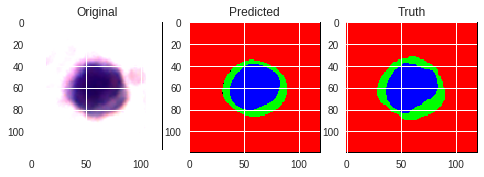

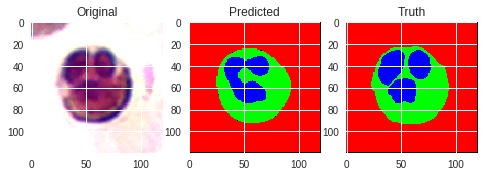

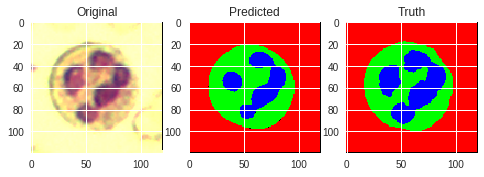

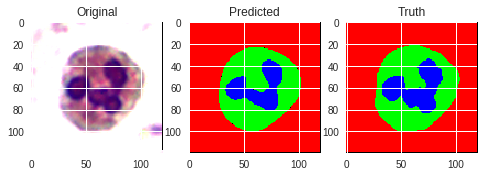

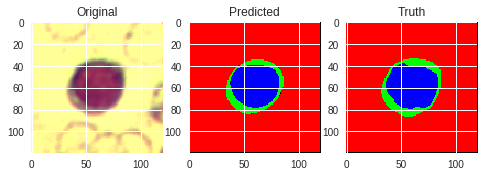

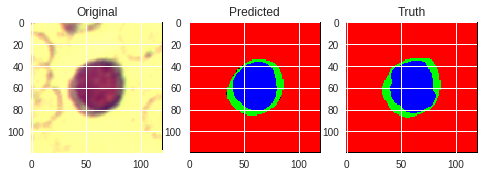

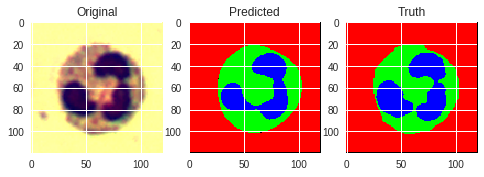

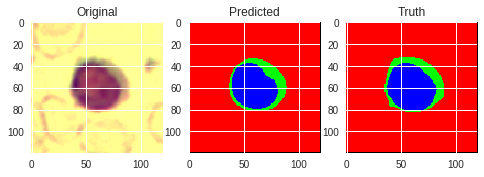

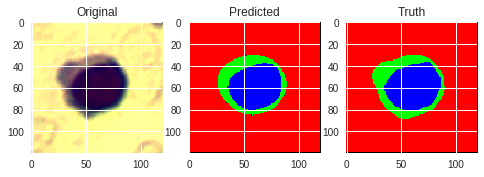

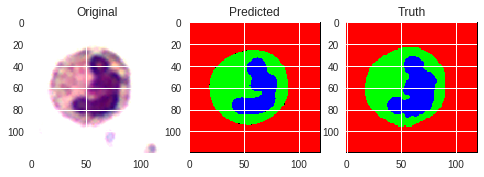

In [0]:
for i in range(30):
  fig = plt.figure()
  a=fig.add_subplot(1,3,1)
  plt.imshow(X_test[i])
  a.set_title('Original')
  a=fig.add_subplot(1,3,2)
  plt.imshow(p[i])
  a.set_title('Predicted')
  a=fig.add_subplot(1,3,3)
  plt.imshow(Y_test[i])
  a.set_title('Truth')
  plt.show()

Jaccard similarity

In [0]:
y_true = np.reshape(Y_test, (30, 3, 120*120))
y_pred = np.reshape(p, (30, 3, 120*120))

cyto = []
nucl = []

for i in range(30):
  print(i)
  print("cytoplasm similarity:")
  jac = jaccard_similarity_score(y_true[i][1], y_pred[i][1])
  cyto.append(jac)
  print(jac)
  print("nucleus similarity:")
  jac = jaccard_similarity_score(y_true[i][2], y_pred[i][2])
  nucl.append(jac)
  print(jac)

0
cytoplasm similarity:
0.9395833333333333
nucleus similarity:
0.983125
1
cytoplasm similarity:
0.9447222222222222
nucleus similarity:
0.9735416666666666
2
cytoplasm similarity:
0.9602777777777778
nucleus similarity:
0.98375
3
cytoplasm similarity:
0.9282638888888889
nucleus similarity:
0.9664583333333333
4
cytoplasm similarity:
0.9572222222222222
nucleus similarity:
0.9956944444444444
5
cytoplasm similarity:
0.954375
nucleus similarity:
0.989375
6
cytoplasm similarity:
0.9690972222222223
nucleus similarity:
0.9749305555555555
7
cytoplasm similarity:
0.9686111111111111
nucleus similarity:
0.9933333333333333
8
cytoplasm similarity:
0.9639583333333334
nucleus similarity:
0.9800694444444444
9
cytoplasm similarity:
0.9776388888888888
nucleus similarity:
0.9955555555555555
10
cytoplasm similarity:
0.966875
nucleus similarity:
0.9756944444444444
11
cytoplasm similarity:
0.9541666666666667
nucleus similarity:
0.9683333333333334
12
cytoplasm similarity:
0.9618055555555556
nucleus similarity:
0

In [0]:
m = np.array(cyto).mean()
s = np.array(cyto).std()
print("cytoplasm jaccard index mean:", m.round(8) , "+/-", (s/np.sqrt(30)).round(8))
m = np.array(nucl).mean()
s = np.array(nucl).std()
print("nucleus jaccard index mean:", m.round(8) , "+/-", (s/np.sqrt(30)).round(8))

cytoplasm jaccard index mean: 0.95601389 +/- 0.0022943
nucleus jaccard index mean: 0.98230093 +/- 0.00165425


Dice Similarity Coefficient

In [0]:
cyto = []
nucl = []

for i in range(30):
  print(i)
  print("cytoplasm similarity:")
  f1 = f1_score(y_true[i][1], y_pred[i][1], average='binary')
  cyto.append(f1)
  print(f1)
  print("nucleus similarity:")
  f1 = f1_score(y_true[i][2], y_pred[i][2], average='binary')
  nucl.append(f1)
  print(f1)

0
cytoplasm similarity:
0.9085942424879178
nucleus similarity:
0.973811833171678
1
cytoplasm similarity:
0.9163689850808993
nucleus similarity:
0.9589483891822002
2
cytoplasm similarity:
0.9398780744166492
nucleus similarity:
0.9747844827586207
3
cytoplasm similarity:
0.8913889180948374
nucleus similarity:
0.9479581941601121
4
cytoplasm similarity:
0.9352805211178821
nucleus similarity:
0.9933160845191893
5
cytoplasm similarity:
0.9309801449732116
nucleus similarity:
0.9835111542192047
6
cytoplasm similarity:
0.9532415677209204
nucleus similarity:
0.9610949455760319
7
cytoplasm similarity:
0.9525210084033613
nucleus similarity:
0.9896551724137931
8
cytoplasm similarity:
0.94546600819586
nucleus similarity:
0.9690766081241245
9
cytoplasm similarity:
0.9661693633116202
nucleus similarity:
0.9931049342814049
10
cytoplasm similarity:
0.9498791636019754
nucleus similarity:
0.9622844827586207
11
cytoplasm similarity:
0.9306285474038261
nucleus similarity:
0.9508620689655173
12
cytoplasm simi

In [0]:
m = np.array(cyto).mean()
s = np.array(cyto).std()
print("cytoplasm Dice Similarity Coefficient mean:", m.round(8) , "+/-", (s/np.sqrt(30)).round(8))
m = np.array(nucl).mean()
s = np.array(nucl).std()
print("nucleus Dice Similarity Coefficient mean:", m.round(8) , "+/-", (s/np.sqrt(30)).round(8))

cytoplasm Dice Similarity Coefficient mean: 0.93344109 +/- 0.00347193
nucleus Dice Similarity Coefficient mean: 0.97253577 +/- 0.00256696
